In [1]:
import pandas as pd
from neuralprophet import NeuralProphet
import matplotlib.pyplot as plt

In [425]:
data=pd.read_excel('C:/Users/USER/Desktop/진행중/FEMS/datamart/무림페이퍼_15분사용전력_210401-220630.xlsx')
data.columns
data=data.drop(['등록시각'],axis=1)

data['기준시각']=pd.to_datetime(data['기준시각'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42766 entries, 0 to 42765
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   기준시각         42766 non-null  datetime64[ns]
 1   직전 15분 사용전력  42766 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 668.3 KB


###       ACF 확인

In [ ]:
def acf_plot(data, N_LAGS, pval):
    from statsmodels.graphics.tsaplots import plot_acf
    
    auto = pd.Series(data.values)
    for i in range(0, N_LAGS+1):
        print(f"lag at {i}'s autocorrelation = ", round(auto.autocorr(lag=i),2))
        scatter = pd.DataFrame()
        scatter['lags'] = [i for i in range (1, N_LAGS +1)]
        scatter['autocorrelation'] = [ auto.autocorr(lag=i) for i in range(1, N_LAGS +1)]

    fig = plot_acf(data, lags=N_LAGS, alpha=pval)
    plt.xlabel(f'Lag at k (0 to {N_LAGS})')
    plt.ylabel("lag at k's autocorrelation")
    plt.scatter(x=scatter['lags'], y=scatter['autocorrelation'], edgecolors='red',linewidth=1, s=200, alpha = .5)
    plt.show()

acf_plot(data['직전 15분 사용전력'].diff(1), 10, 0.05)
# acf_plot(data['직전 15분 사용전력'].diff(5), 30, 0.05)


### feature 생성

In [357]:
#lag (Auto Regression) lag 1까지 생성
data['l_1'] = data['직전 15분 사용전력'].shift(1)
data['l_2']= data['직전 15분 사용전력'].shift(2)
data['l_3']= data['직전 15분 사용전력'].shift(3)
# data['l_4']= data['직전 15분 사용전력'].shift(4)
# data['l_5']= data['직전 15분 사용전력'].shift(5)
# data['l_6']= data['직전 15분 사용전력'].shift(6)
# data['l_7']= data['직전 15분 사용전력'].shift(7)
# data['l_8']= data['직전 15분 사용전력'].shift(8)
# data['l_9']= data['직전 15분 사용전력'].shift(9)
# data['l_10']= data['직전 15분 사용전력'].shift(10)

In [426]:
#diff 1 차분(직전, 직직전의 차이)
data['d_2']=data['직전 15분 사용전력'].diff(1).shift(1)
data['d_3']=data['직전 15분 사용전력'].diff(2).shift(1)
data['d_4']=data['직전 15분 사용전력'].diff(3).shift(1)
data['d_5']=data['직전 15분 사용전력'].diff(4).shift(1)
data['d_6']=data['직전 15분 사용전력'].diff(5).shift(1)


In [427]:
data

,기준시각,직전 15분 사용전력,d_2,d_3,d_4,d_5,d_6
0,2021-04-01 00:00:00,7224.0,NaN,NaN,NaN,NaN,NaN
1,2021-04-01 00:15:00,7274.4,NaN,NaN,NaN,NaN,NaN
2,2021-04-01 00:30:00,7442.4,50.4,NaN,NaN,NaN,NaN
3,2021-04-01 00:45:00,7392.0,168.0,218.4,NaN,NaN,NaN
4,2021-04-01 01:00:00,7576.8,-50.4,117.6,168.0,NaN,NaN
...,...,...,...,...,...,...,...
42761,2022-06-30 22:45:00,5628.0,50.4,0.0,-33.6,0.0,-201.6
42762,2022-06-30 23:00:00,5560.8,-16.8,33.6,-16.8,-50.4,-16.8
42763,2022-06-30 23:15:00,5493.6,-67.2,-84.0,-33.6,-84.0,-117.6
42764,2022-06-30 23:30:00,5527.2,-67.2,-134.4,-151.2,-100.8,-151.2


In [6]:
# 결측 보강(interplation)
# data=data.fillna(method='bfill')
# data=data.dropna()
# data

,기준시각,직전 15분 사용전력,l_2,d_2
2,2021-04-01 00:30:00,7442.4,7224.0,50.4
3,2021-04-01 00:45:00,7392.0,7274.4,168.0
4,2021-04-01 01:00:00,7576.8,7442.4,-50.4
5,2021-04-01 01:15:00,7492.8,7392.0,184.8
6,2021-04-01 01:30:00,7660.8,7576.8,-84.0
...,...,...,...,...
42761,2022-06-30 22:45:00,5628.0,5594.4,50.4
42762,2022-06-30 23:00:00,5560.8,5644.8,-16.8
42763,2022-06-30 23:15:00,5493.6,5628.0,-67.2
42764,2022-06-30 23:30:00,5527.2,5560.8,-67.2


In [428]:
#train_test split
def train_test_split(data_t,train_cut_date,val_cut_date,end_time): 
  
    df_train = data_t[data_t['기준시각'] < train_cut_date ]
    df_val= data_t[(data_t['기준시각'] >= train_cut_date ) & (data_t['기준시각'] < val_cut_date )]
    df_test = data_t[(data_t['기준시각'] >= val_cut_date)& (data_t['기준시각'] < end_time )] 
    
    return (df_train,df_val,df_test) 

df_train,df_val,df_test=train_test_split(data,'2022-06-30','2022-06-30','2022-06-30 23:00:00')
print('train_df=',min(df_train['기준시각']),'~',max(df_train['기준시각']),',',len(df_train))
# print('val_df=',min(df_val['기준시각']),'~',max(df_val['기준시각']),',',len(df_val))
print('test_df=',min(df_test['기준시각']),'~',max(df_test['기준시각']),',',len(df_test))


train_df= 2021-04-01 00:00:00 ~ 2022-06-29 23:45:00 , 42670
test_df= 2022-06-30 00:00:00 ~ 2022-06-30 22:45:00 , 92


In [430]:
df_train.rename(columns={"기준시각": "ds", "직전 15분 사용전력": "y"}, inplace=True)
# df_val.rename(columns={"기준시각": "ds", "직전 15분 사용전력": "y"}, inplace=True)
df_test.rename(columns={"기준시각": "ds", "직전 15분 사용전력": "y"}, inplace=True)

WARNING - (py.warnings._showwarnmsg) - C:\Users\USER\AppData\Local\Temp\ipykernel_12428\4173171199.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


WARNING - (py.warnings._showwarnmsg) - C:\Users\USER\AppData\Local\Temp\ipykernel_12428\4173171199.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




#### Y Scaling(minmax)

In [160]:
from sklearn.preprocessing import MinMaxScaler
# Y
minmax_scaler=MinMaxScaler()
minmax_scaler.fit(np.array(df_train['y']).reshape(-1,1))
df_train['y']=minmax_scaler.transform(np.array(df_train['y']).reshape(-1,1))
# feature
minmax_scaler2=MinMaxScaler()
minmax_scaler2.fit(np.array(df_train['d_2']).reshape(-1,1))
df_train['d_2']=minmax_scaler2.transform(np.array(df_train['d_2']).reshape(-1,1))

WARNING - (py.warnings._showwarnmsg) - C:\Users\USER\AppData\Local\Temp\ipykernel_12428\1418040195.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


WARNING - (py.warnings._showwarnmsg) - C:\Users\USER\AppData\Local\Temp\ipykernel_12428\1418040195.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




In [161]:
df_train

,ds,y,d_2
0,2021-04-01 00:00:00,0.806517,NaN
1,2021-04-01 00:15:00,0.812627,NaN
2,2021-04-01 00:30:00,0.832994,0.766169
3,2021-04-01 00:45:00,0.826884,0.783582
4,2021-04-01 01:00:00,0.849287,0.751244
...,...,...,...
39689,2022-05-29 22:45:00,0.643585,0.741294
39690,2022-05-29 23:00:00,0.653768,0.761194
39691,2022-05-29 23:15:00,0.655804,0.771144
39692,2022-05-29 23:30:00,0.639511,0.761194


#### model

In [444]:
model_tune = NeuralProphet(
# n_lags=3,
# n_forecasts=3,
num_hidden_layers=2,
impute_missing= "True",
normalize="auto",
# changepoints_range=0.95,
# n_changepoints=5,
learning_rate=0.1,
d_hidden=8
)
# model_tune = model_tune.add_lagged_regressor(names='l_1',normalize='minmax')
# model_tune = model_tune.add_lagged_regressor(names='l_2',normalize='minmax')
# model_tune = model_tune.add_lagged_regressor(names='l_3',normalize='minmax')
# model_tune = model_tune.add_lagged_regressor(names='l_4',normalize='minmax')
# model_tune = model_tune.add_lagged_regressor(names='l_5',normalize='minmax')
# model_tune = model_tune.add_lagged_regressor(names='l_6',normalize='minmax')
# model_tune = model_tune.add_lagged_regressor(names='l_7',normalize='minmax')
# model_tune = model_tune.add_lagged_regressor(names='l_8',normalize='minmax')
# model_tune = model_tune.add_lagged_regressor(names='l_9',normalize='minmax')
# model_tune = model_tune.add_lagged_regressor(names='l_10',normalize='minmax')
# # model_tune = model_tune.add_future_regressor(name='l_2',normalize='minmax')
model_tune = model_tune.add_future_regressor(name='d_2',normalize='minmax')   #regularization=0.05
model_tune = model_tune.add_future_regressor(name='d_3',normalize='minmax')   #regularization=0.05
model_tune = model_tune.add_future_regressor(name='d_4',normalize='minmax')   #regularization=0.05
model_tune = model_tune.add_future_regressor(name='d_5',normalize='minmax')   #regularization=0.05
model_tune = model_tune.add_future_regressor(name='d_6',normalize='minmax')   #regularization=0.05



In [137]:
# from locale import normalize


# model=NeuralProphet(n_lag=7)
# model = model.add_future_regressor(name='l_1',normalize='minmax')
# model = model.add_future_regressor(name='l_2',normalize='minmax')
# model = model.add_future_regressor(name='l_3',normalize='minmax')
# model = model.add_future_regressor(name='l_4',normalize='minmax')
# model = model.add_future_regressor(name='l_5',normalize='minmax')
# model = model.add_future_regressor(name='l_6',normalize='minmax')
# model = model.add_future_regressor(name='l_7',normalize='minmax')

In [445]:
#학습데이터, 검증데이터 분리
train, val = model_tune.split_df(df_train, valid_p = 0.1)
print(len(train),len(val))
train


INFO - (NP.df_utils._infer_frequency) - Major frequency 15T corresponds to 99.984% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as 15T
INFO - (NP.forecaster.__handle_missing_data) - 2 NaN values in column d_2 were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 3 NaN values in column d_3 were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 4 NaN values in column d_4 were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 5 NaN values in column d_5 were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 6 NaN values in column d_6 were auto-imputed.


38403 4267


,ds,y,d_2,d_3,d_4,d_5,d_6
0,2021-04-01 00:00:00,7224.0,50.4,218.4,168.0,352.8,130.8
1,2021-04-01 00:15:00,7274.4,50.4,218.4,168.0,352.8,268.8
2,2021-04-01 00:30:00,7442.4,50.4,218.4,168.0,352.8,268.8
3,2021-04-01 00:45:00,7392.0,168.0,218.4,168.0,352.8,268.8
4,2021-04-01 01:00:00,7576.8,-50.4,117.6,168.0,352.8,268.8
...,...,...,...,...,...,...,...
38398,2022-05-16 12:00:00,6232.8,100.8,-50.4,-117.6,-201.6,-50.4
38399,2022-05-16 12:15:00,6098.4,235.2,336.0,184.8,117.6,33.6
38400,2022-05-16 12:30:00,6064.8,-134.4,100.8,201.6,50.4,-16.8
38401,2022-05-16 12:45:00,6232.8,-33.6,-168.0,67.2,168.0,16.8


In [446]:
future = model_tune.make_future_dataframe(df=df_train,periods=4*24)

INFO - (NP.df_utils._infer_frequency) - Major frequency 15T corresponds to 99.984% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as 15T


ValueError: Future values of all user specified regressors not provided

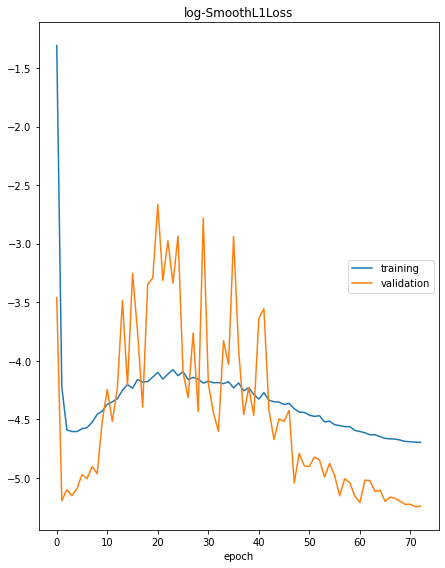

log-SmoothL1Loss
	training         	 (min:   -4.697, max:   -1.307, cur:   -4.697)
	validation       	 (min:   -5.247, max:   -2.665, cur:   -5.242)


In [438]:
from enum import auto
# model_tune = model_tune.highlight_nth_step_ahead_of_each_forecast(model_tune.n_forecasts)
metrics = model_tune.fit(train,validation_df=val,progress='plot')    #,freq='6H')

In [439]:
metrics

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
0,0.270629,4601.264959,5591.611550,0.0,0.031340,1593.735083,1930.110004
1,0.014612,864.547723,1274.891280,0.0,0.005543,557.814082,729.746755
2,0.010143,652.390360,1071.843542,0.0,0.006085,575.185595,758.870262
3,0.010002,660.266932,1067.177848,0.0,0.005781,559.281936,735.691980
4,0.010004,672.838556,1068.363426,0.0,0.006148,568.032123,757.748192
...,...,...,...,...,...,...,...
68,0.009298,658.483319,1034.513236,0.0,0.005506,550.957071,724.794283
69,0.009190,648.087456,1027.007343,0.0,0.005371,555.291410,725.991650
70,0.009167,646.002987,1025.638635,0.0,0.005375,566.362241,733.699476
71,0.009139,643.801372,1023.103701,0.0,0.005262,551.918361,720.226530


In [440]:
#metric 확인
print("SmoothL1Loss: ", metrics.SmoothL1Loss.tail(1).item())
print("MAE(Train): ", metrics.MAE.tail(1).item())
print("MAE(val): ", metrics.MAE_val.tail(1).item())

SmoothL1Loss:  0.00912266976884634
MAE(Train):  642.4084945323892
MAE(val):  551.7100381504771


In [171]:
# #loss 그래프
# import plotly.express as px
# px.line(metrics, y=['MAE', 'MAE_val'], width=800, height=400)

In [189]:
# df_test=df_test.drop(['y'],axis=1)
# Y
# minmax_scaler=MinMaxScaler()
# minmax_scaler.fit(np.array(df_train['y']).reshape(-1,1))
# df_test['y']=minmax_scaler.transform(np.array(df_test['y']).reshape(-1,1))
# # feature
# minmax_scaler2=MinMaxScaler()
# minmax_scaler2.fit(np.array(df_train['d_2']).reshape(-1,1))
# df_test['d_2']=minmax_scaler2.transform(np.array(df_test['d_2']).reshape(-1,1))
# df_test

WARNING - (py.warnings._showwarnmsg) - C:\Users\USER\AppData\Local\Temp\ipykernel_12428\3133985708.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


WARNING - (py.warnings._showwarnmsg) - C:\Users\USER\AppData\Local\Temp\ipykernel_12428\3133985708.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




,ds,y,d_2
42670,2022-06-30 00:00:00,5846.4,-8.4
42671,2022-06-30 00:15:00,5812.8,-75.6
42672,2022-06-30 00:30:00,5745.6,-33.6
42673,2022-06-30 00:45:00,5712.0,-67.2
42674,2022-06-30 01:00:00,5745.6,-33.6
...,...,...,...
42757,2022-06-30 21:45:00,5678.4,-201.6
42758,2022-06-30 22:00:00,5644.8,33.6
42759,2022-06-30 22:15:00,5594.4,-33.6
42760,2022-06-30 22:30:00,5644.8,-50.4


INFO - (NP.df_utils._infer_frequency) - Major frequency 15T corresponds to 99.984% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 15T


ValueError: Future values of all user specified regressors not provided

INFO - (NP.df_utils._infer_frequency) - Major frequency 15T corresponds to 98.958% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 15T
INFO - (NP.df_utils._infer_frequency) - Major frequency 15T corresponds to 98.958% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 15T
WARNING - (py.warnings._showwarnmsg) - c:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\neuralprophet\forecaster.py:1406: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.




Text(0.5, 1.0, 'moorim_demand')

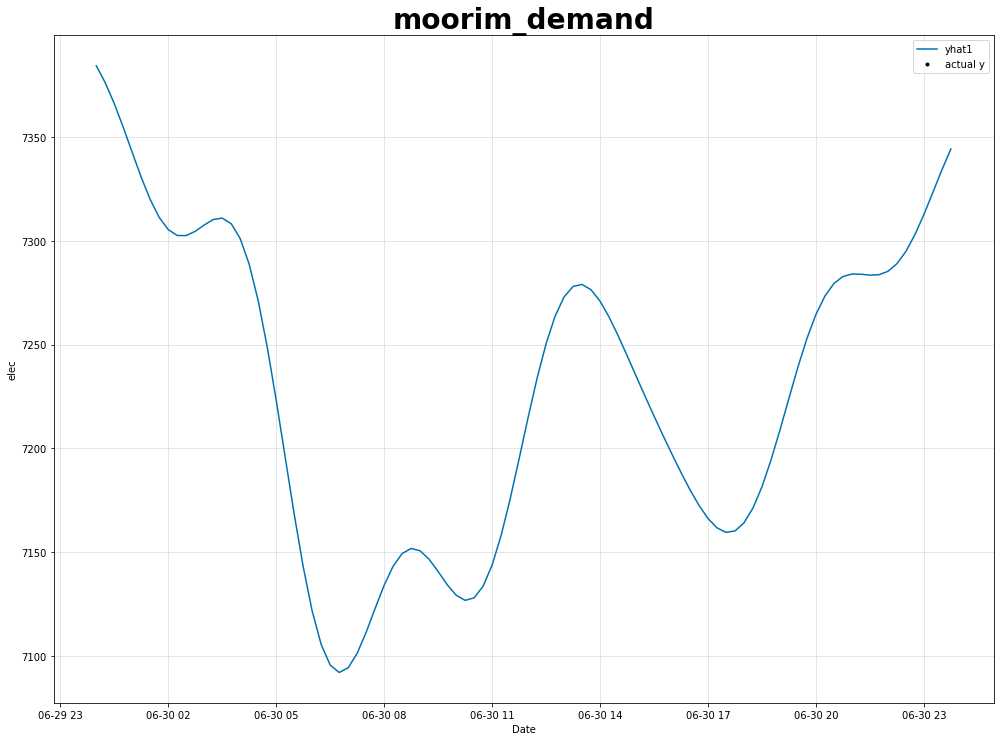

In [422]:
forecast = model_tune.predict(future)
# fig=model_tune.plot(forecast[['ds','y','yhat1']])


fig, ax = plt.subplots(figsize=(14, 10)) 
# model_tune.highlight_nth_step_ahead_of_each_forecast(model_tune.n_forecasts)
model_tune.plot(forecast, xlabel="Date", ylabel="elec", ax=ax)
ax.set_title("moorim_demand", fontsize=28, fontweight="bold")


In [423]:
forecast


,ds,y,yhat1,residual1,trend,season_weekly,season_daily
0,2022-06-30 00:00:00,None,7384.279785,NaN,6791.403809,593.714478,-0.838261
1,2022-06-30 00:15:00,None,7376.038574,NaN,6791.384277,586.593079,-1.939253
2,2022-06-30 00:30:00,None,7366.009766,NaN,6791.364746,579.478577,-4.833465
3,2022-06-30 00:45:00,None,7354.573242,NaN,6791.345215,572.377441,-9.149360
4,2022-06-30 01:00:00,None,7342.431152,NaN,6791.325684,565.296387,-14.190886
...,...,...,...,...,...,...,...
91,2022-06-30 22:45:00,None,7302.899902,NaN,6789.629395,524.818237,-11.547884
92,2022-06-30 23:00:00,None,7312.618652,NaN,6789.609863,532.493225,-9.484206
93,2022-06-30 23:15:00,None,7323.292480,NaN,6789.590332,540.279602,-6.577374
94,2022-06-30 23:30:00,None,7334.084961,NaN,6789.570801,548.171204,-3.656875


In [424]:
df_test

,ds,y
42670,2022-06-30 00:00:00,5846.4
42671,2022-06-30 00:15:00,5812.8
42672,2022-06-30 00:30:00,5745.6
42673,2022-06-30 00:45:00,5712.0
42674,2022-06-30 01:00:00,5745.6
...,...,...
42757,2022-06-30 21:45:00,5678.4
42758,2022-06-30 22:00:00,5644.8
42759,2022-06-30 22:15:00,5594.4
42760,2022-06-30 22:30:00,5644.8


In [339]:
df_test

,ds,y,d_2,d_3,d_4,d_5,d_6
42670,2022-06-30 00:00:00,5846.4,-8.4,25.2,310.8,243.6,193.2
42671,2022-06-30 00:15:00,5812.8,-75.6,-84.0,-50.4,235.2,168.0
42672,2022-06-30 00:30:00,5745.6,-33.6,-109.2,-117.6,-84.0,201.6
42673,2022-06-30 00:45:00,5712.0,-67.2,-100.8,-176.4,-184.8,-151.2
42674,2022-06-30 01:00:00,5745.6,-33.6,-100.8,-134.4,-210.0,-218.4
...,...,...,...,...,...,...,...
42757,2022-06-30 21:45:00,5678.4,-201.6,-151.2,-16.8,-168.0,-151.2
42758,2022-06-30 22:00:00,5644.8,33.6,-168.0,-117.6,16.8,-134.4
42759,2022-06-30 22:15:00,5594.4,-33.6,0.0,-201.6,-151.2,-16.8
42760,2022-06-30 22:30:00,5644.8,-50.4,-84.0,-50.4,-252.0,-201.6


In [214]:
import numpy as np
def SMAPE(y_true, y_pred):
    return np.mean( (np.abs(y_true-y_pred)) / ((np.abs(y_true) + np.abs(y_pred))/2) ) * 100
SMAPE(forecast['y'],forecast['yhat1'])

4.231247373783391

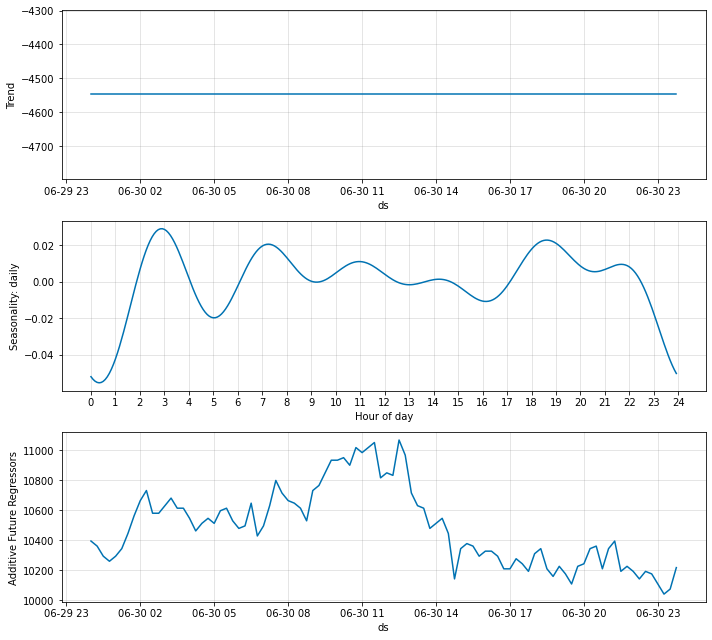

In [322]:
fig_comp = model_tune.plot_components(forecast)

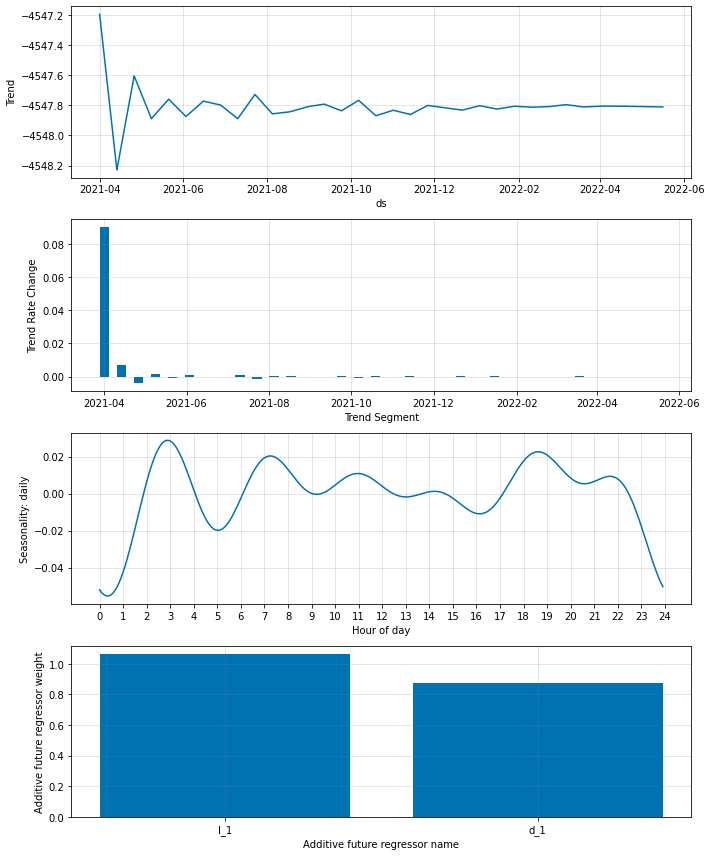

In [323]:
fig_param = model_tune.plot_parameters()

In [ ]:
# future = model.make_future_dataframe(df_test, periods=len(df_test), n_historic_predictions=len(df_test)) 
# forecast = model.predict(future)

### daily average


In [99]:
data=pd.read_csv('C:/Users/USER/Desktop/진행중/FEMS/datamart/(하루평균)무림페이퍼_15분사용전력_210401-220630.csv')
data=data[['date','평균(직전 15분 사용전력)']]

data['date']=pd.to_datetime(data['date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             447 non-null    datetime64[ns]
 1   평균(직전 15분 사용전력)  447 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 7.1 KB


In [103]:
#train_test split
def train_test_split(data_t,train_cut_date,val_cut_date): 
  
    df_train = data_t[data_t['date'] < train_cut_date ]
    # df_val= data_t[(data_t['date'] >= train_cut_date ) & (data_t['기준시각'] < val_cut_date )]
    df_test = data_t[(data_t['date'] >= val_cut_date)] 
    
    return (df_train,df_val,df_test) 

df_train,df_val,df_test=train_test_split(data,'2022-05-25','2022-05-25')
print('train_df=',min(df_train['date']),'~',max(df_train['date']),',',len(df_train))
# print('val_df=',min(df_val['기준시각']),'~',max(df_val['기준시각']),',',len(df_val))
print('test_df=',min(df_test['date']),'~',max(df_test['date']),',',len(df_test))

train_df= 2021-04-01 00:00:00 ~ 2022-05-24 00:00:00 , 410
test_df= 2022-05-25 00:00:00 ~ 2022-06-30 00:00:00 , 37


In [104]:

df_train.rename(columns={"date": "ds", "평균(직전 15분 사용전력)": "y"}, inplace=True)
df_test.rename(columns={"date": "ds", "평균(직전 15분 사용전력)": "y"}, inplace=True)

WARNING - (py.warnings._showwarnmsg) - C:\Users\USER\AppData\Local\Temp\ipykernel_13212\3068202567.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.rename(columns={"date": "ds", "평균(직전 15분 사용전력)": "y"}, inplace=True)

WARNING - (py.warnings._showwarnmsg) - C:\Users\USER\AppData\Local\Temp\ipykernel_13212\3068202567.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.rename(columns={"date": "ds", "평균(직전 15분 사용전력)": "y"}, inplace=True)



In [141]:
future = m.make_future_dataframe(df_test, periods=len(df_test), n_historic_predictions=len(df_test)) 
forecast = m.predict(future)
forecast

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 97.297% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - c:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\neuralprophet\forecaster.py:2060: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.649% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.649% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - c:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\neuralprophet\forecaster.py:1406: FutureWarning:

The fram

,ds,y,yhat1,residual1,trend
0,2022-05-25,7864.675,6834.283203,-1030.391797,6834.283203
1,2022-05-26,7697.2,6834.283203,-862.916797,6834.283203
2,2022-05-27,7769.825,6834.283203,-935.541797,6834.283203
3,2022-05-28,7064.8375,6834.283203,-230.554297,6834.283203
4,2022-05-29,5390.0875,6834.283203,1444.195703,6834.283203
...,...,...,...,...,...
69,2022-08-02,None,6834.283203,NaN,6834.283203
70,2022-08-03,None,6834.283203,NaN,6834.283203
71,2022-08-04,None,6834.283203,NaN,6834.283203
72,2022-08-05,None,6834.283203,NaN,6834.283203


Text(0.5, 1.0, 'demand')

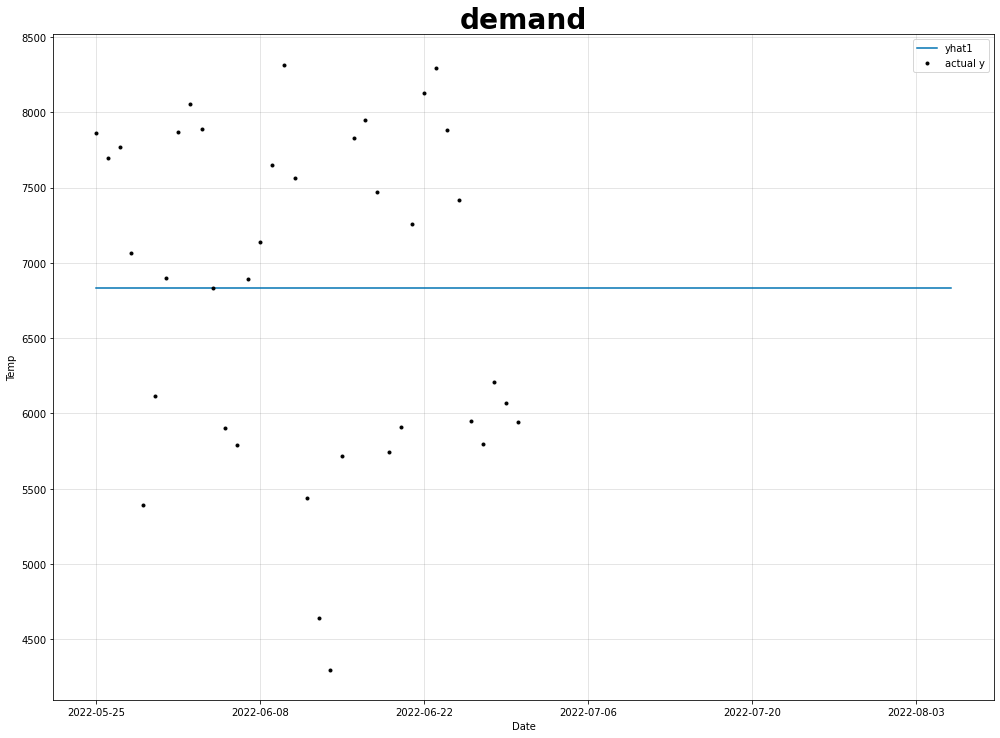

In [142]:
fig, ax = plt.subplots(figsize=(14, 10)) 
m.plot(forecast, xlabel="Date", ylabel="Temp", ax=ax)
ax.set_title("demand", fontsize=28, fontweight="bold")